# LSTM with Embedding

In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
TRAIN_RANGE = (datetime(1949, 1, 1), datetime(1956, 12, 1))
VALID_RANGE = (datetime(1957, 1, 1), datetime(1958, 12, 1))
TEST_RANGE = (datetime(1959, 1, 1), datetime(1960, 12, 1))
TIMESTEPS = 12  # Input 12 months to predict next month

## 1. Read in dataset

In [5]:
data = pd.read_csv('data/airline-passengers.csv')
data.index = pd.to_datetime(data.Month)  # Set datetime index
data.drop(['Month'], axis=1, inplace=True)

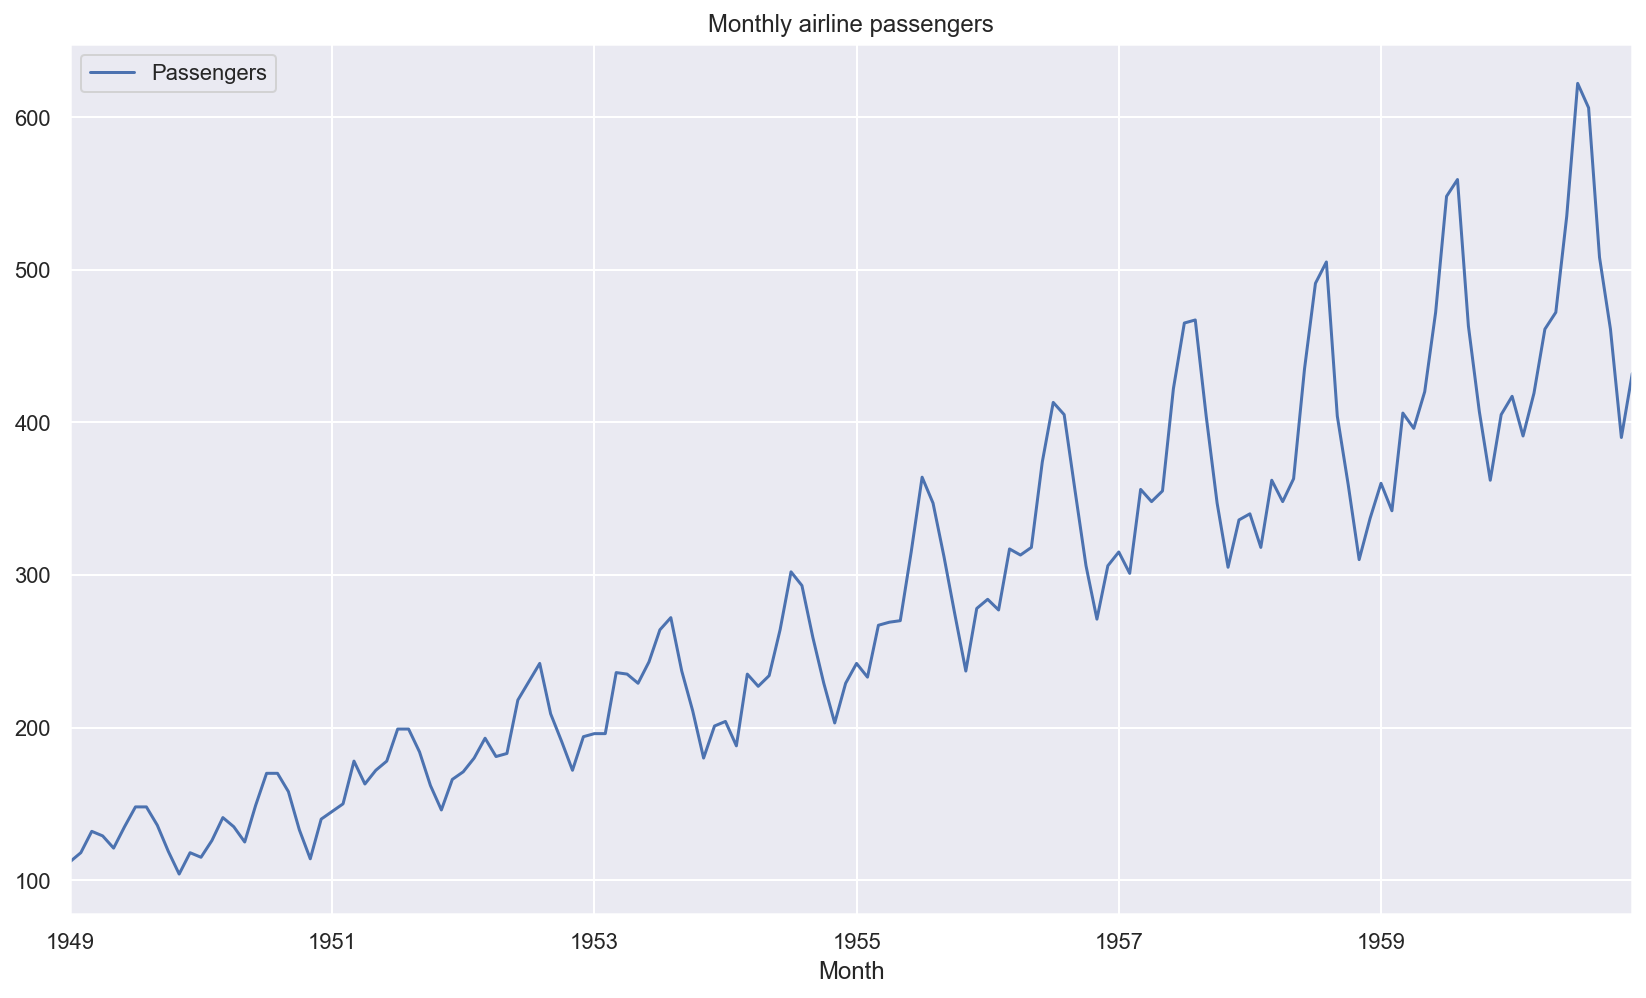

In [6]:
data.plot(figsize=(14, 8), title='Monthly airline passengers')

## 2.1 Normalize dataset

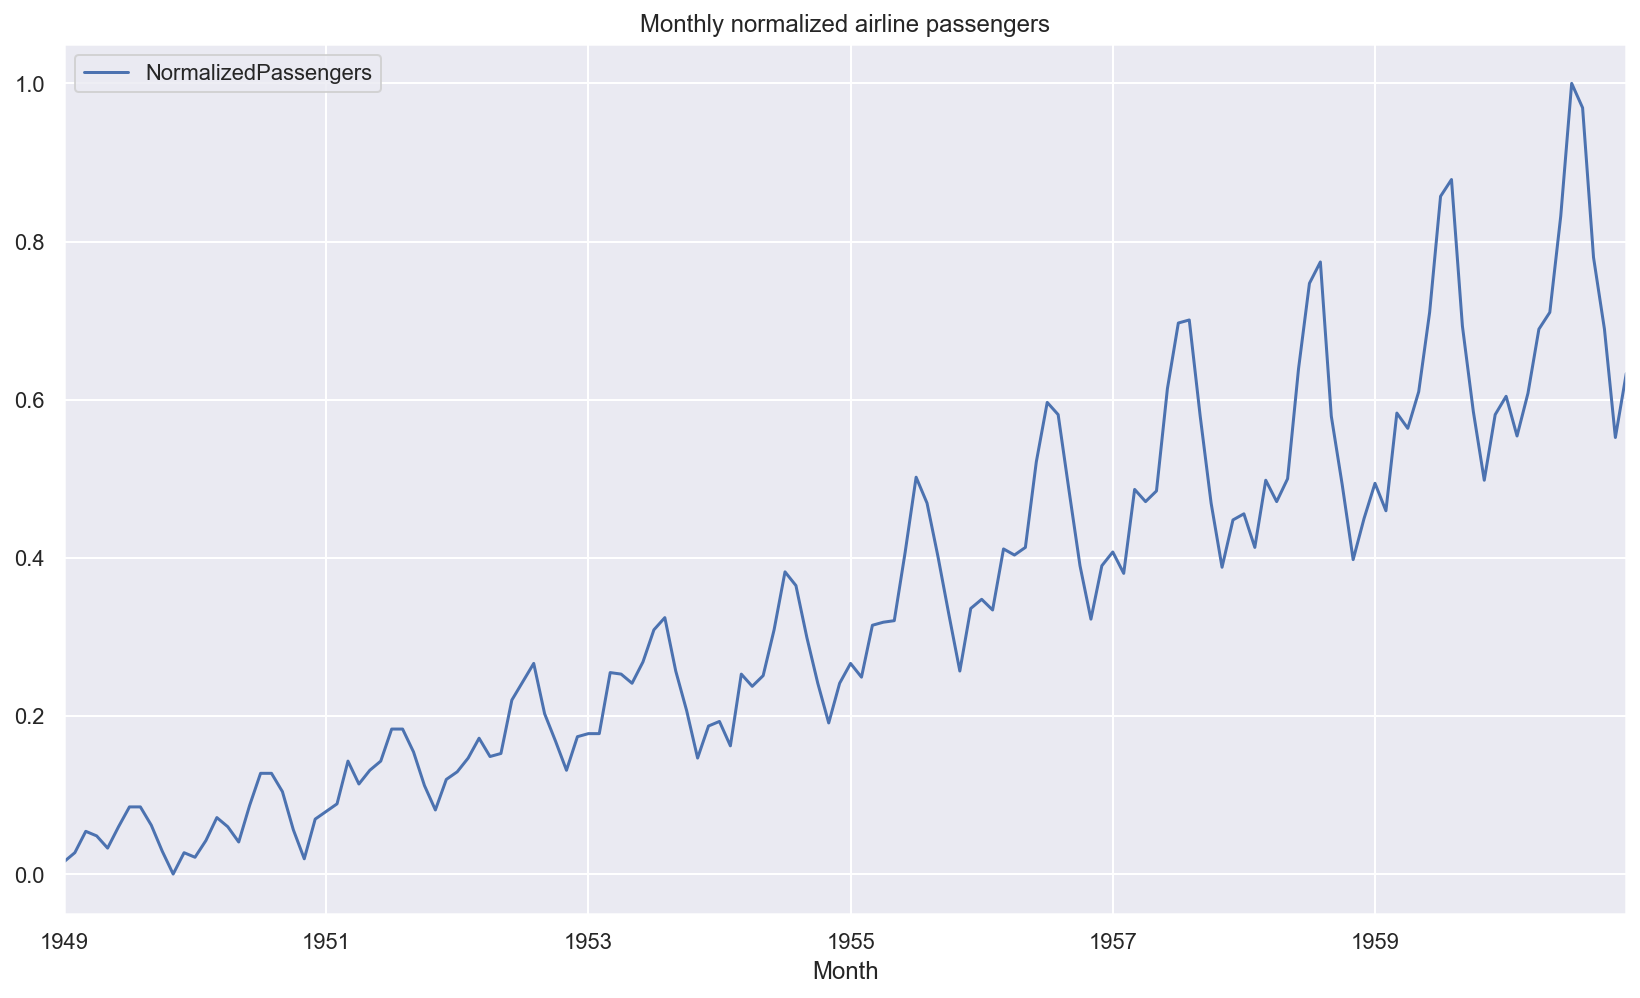

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['NormalizedPassengers'] = scaler.fit_transform(data['Passengers'].values.reshape(-1, 1)).flatten()
data[['NormalizedPassengers']].plot(figsize=(14, 8), title='Monthly normalized airline passengers')

## 2.2 Preprocess dataset

In [8]:
def create_dataset(data, timesteps=TIMESTEPS):
    """Create input and output pairs for training lstm.
    Params:
        data (pandas.DataFrame): Normalized dataset
        timesteps (int, default: TIMESTEPS): Input time length 
    Returns:
        X (numpy.array): Input for lstm
        y (numpy.array): Output for lstm
        y_date (list): Datetime of output
        start_values (list): Start valeus of each input
    """
    X, y, y_date, start_values = [], [], [], []
    
    for i in range(len(data) - timesteps):
        Xt = data.iloc[i:i+timesteps].values
        yt = data.iloc[i+timesteps]
        yt_date = data.index[i+timesteps].to_pydatetime()
        
        # Subtract a start value from each values in the timestep.
        start_value = Xt[0]
        Xt = Xt - start_value
        yt = yt - start_value
        
        X.append(Xt)
        y.append(yt)
        y_date.append(yt_date)
        start_values.append(start_value)
        
    return np.array(X), np.array(y), y_date, start_values

In [9]:
def split_train_valid_test(X, y, y_date, train_range=TRAIN_RANGE, valid_range=VALID_RANGE, test_range=TEST_RANGE):
    """Split X and y into train, valid, and test periods.
    Params:
        X (numpy.array): Input for lstm
        y (numpy.array): Output for lstm
        y_date (list): Datetime of output
        train_range (tuple): Train period
        valid_range (tuple): Validation period
        test_range (tuple): Test period
    Returns:
        X_train (pandas.DataFrame)
        X_valid (pandas.DataFrame)
        X_test (pandas.DataFrame)
        y_train (pandas.DataFrame)
        y_valid (pandas.DataFrame)
        y_test (pandas.DataFrame)
        y_date_train (list)
        y_date_valid (list)
        y_date_test (list)
    """
    train_end_idx = y_date.index(train_range[1])
    valid_end_idx = y_date.index(valid_range[1])
    
    X_train = X[:train_end_idx+1, :]
    X_valid = X[train_end_idx+1:valid_end_idx+1, :]
    X_test = X[valid_end_idx+1:, :]
    
    y_train = y[:train_end_idx+1]
    y_valid = y[train_end_idx+1:valid_end_idx+1]
    y_test = y[valid_end_idx+1:]
    
    y_date_train = y_date[:train_end_idx+1]
    y_date_valid = y_date[train_end_idx+1:valid_end_idx+1]
    y_date_test = y_date[valid_end_idx+1:]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test

In [10]:
# Create input and output pairs for training lstm.
X, y, y_date, start_values = create_dataset(data[['NormalizedPassengers']])

# Split X and y into train, valid, and test periods.
X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test = split_train_valid_test(X, y, y_date)

In [11]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(84, 12, 1) (24, 12, 1) (24, 12, 1)
(84, 1) (24, 1) (24, 1)


## 3. Create stacked LSTM regression model

In [12]:
def create_model(timesteps=TIMESTEPS):
    # Create encoder
    encoder_inputs = Input(shape=(timesteps, 1), name='encoder_input')
    encoder, state_h1, state_c1 = LSTM(128, return_sequences=True, return_state=True, name='encoder_lstm_1')(encoder_inputs)
    encoder_states1 = [state_h1, state_c1]
    
    encoder_outputs, state_h2, state_c2 = LSTM(32, return_state=True, name='encoder_lstm_2')(encoder)
    encoder_states2 = [state_h2, state_c2]

    # Create decoder
    decoder_inputs = Input(shape=(timesteps, 1), name='decoder_input')    
    decoder, _, _ = LSTM(128, return_sequences=True, return_state=True, name='decoder_lstm_1')(decoder_inputs, initial_state=encoder_states1)
    # decoder, _, _ = LSTM(32, return_sequences=True, return_state=True, name='decoder_lstm_2')(decoder, initial_state=encoder_states2)
    decoder, _, _ = LSTM(32, return_sequences=False, return_state=True, name='decoder_lstm_2')(decoder, initial_state=encoder_states2)

    
    # Create output layer
    decoder_outputs = Dense(1)(decoder)
    
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.01), metrics=['mean_absolute_error'])
    return model

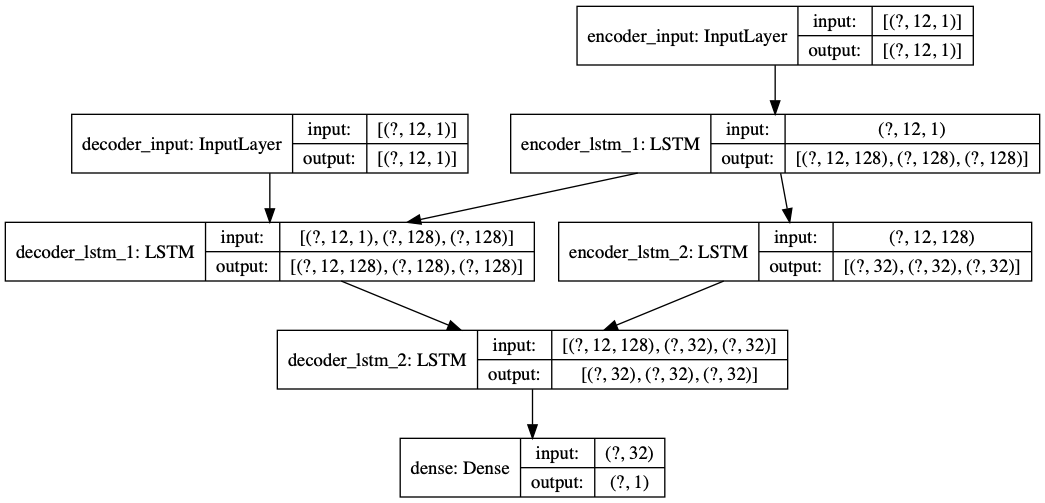

In [13]:
# Create model
model = create_model()
plot_model(model, show_shapes=True)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm_1 (LSTM)           [(None, 12, 128), (N 66560       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm_1 (LSTM)           [(None, 12, 128), (N 66560       decoder_input[0][0]              
                                                                 encoder_lstm_1[0][1]         

In [15]:
# Callbacks of training.
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=15, verbose=1, mode='auto')
fn = 'trained_model.h5'
mc = ModelCheckpoint(filepath=fn, save_best_only=True)
callbacks = [es, mc]

In [16]:
# Start training model.
fit = model.fit(
    [X_train, X_train], y_train, 
    batch_size=32,
    epochs=1000, 
    verbose=2,
    validation_data=([X_valid, X_valid], y_valid), 
    callbacks=callbacks)

Train on 84 samples, validate on 24 samples
Epoch 1/1000
84/84 - 5s - loss: 0.0259 - mean_absolute_error: 0.1295 - val_loss: 0.0055 - val_mean_absolute_error: 0.0571
Epoch 2/1000
84/84 - 0s - loss: 0.0027 - mean_absolute_error: 0.0438 - val_loss: 0.0022 - val_mean_absolute_error: 0.0391
Epoch 3/1000
84/84 - 0s - loss: 0.0011 - mean_absolute_error: 0.0267 - val_loss: 0.0017 - val_mean_absolute_error: 0.0345
Epoch 4/1000
84/84 - 0s - loss: 0.0013 - mean_absolute_error: 0.0292 - val_loss: 0.0014 - val_mean_absolute_error: 0.0299
Epoch 5/1000
84/84 - 0s - loss: 0.0011 - mean_absolute_error: 0.0267 - val_loss: 0.0013 - val_mean_absolute_error: 0.0295
Epoch 6/1000
84/84 - 0s - loss: 0.0010 - mean_absolute_error: 0.0251 - val_loss: 0.0011 - val_mean_absolute_error: 0.0291
Epoch 7/1000
84/84 - 0s - loss: 9.5263e-04 - mean_absolute_error: 0.0246 - val_loss: 0.0011 - val_mean_absolute_error: 0.0286
Epoch 8/1000
84/84 - 0s - loss: 9.1121e-04 - mean_absolute_error: 0.0239 - val_loss: 0.0012 - val_

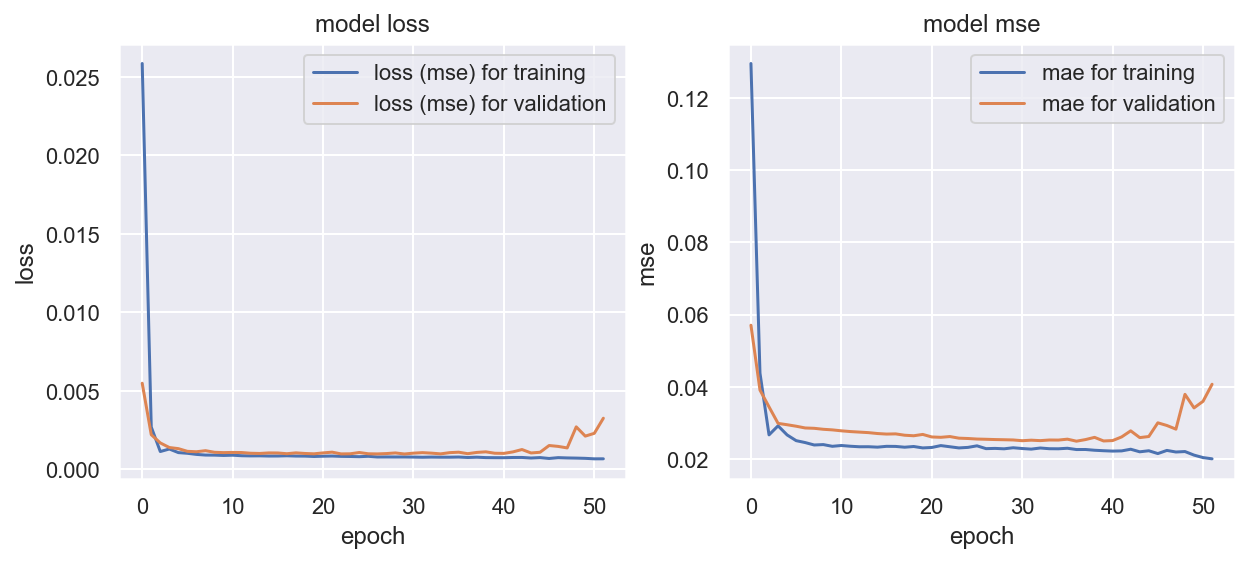

In [17]:
# Plot training history
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 4))
axL.plot(fit.history['loss'], label="loss (mse) for training")
axL.plot(fit.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(fit.history['mean_absolute_error'], label="mae for training")
axR.plot(fit.history['val_mean_absolute_error'], label="mae for validation")
axR.set_title('model mse')
axR.set_xlabel('epoch')
axR.set_ylabel('mse')
axR.legend(loc='upper right')

plt.show()

# Load best model
model = load_model(fn)

In [18]:
def evaluate_model(data, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model):
    """Evaluate trained model by rmse (root mean squared error) and mae (mean absolute error)'"""
    
    # Predict next month passengers
    pred_train = model.predict([X_train, X_train])
    pred_valid = model.predict([X_valid, X_valid])
    pred_test = model.predict([X_test, X_test])
    
    # Add start_values that were subtracted when preprocessing.
    pred_train  = pred_train + start_values[:len(X_train)]
    pred_valid  = pred_valid + start_values[len(X_train):len(X_train)+len(X_valid)]
    pred_test  = pred_test + start_values[len(X_train)+len(X_valid):]
    
    # Inverse transform normalization
    pred_train = scaler.inverse_transform(pred_train).flatten()
    pred_valid = scaler.inverse_transform(pred_valid).flatten()
    pred_test = scaler.inverse_transform(pred_test).flatten()
    
    pred_df = data.copy()
    pred_df.loc[y_date_train[0]:y_date_train[-1], 'PredictionTrain'] = pred_train
    pred_df.loc[y_date_valid[0]:y_date_valid[-1], 'PredictionValid'] = pred_valid
    pred_df.loc[y_date_test[0]:y_date_test[-1], 'PredictionTest'] = pred_test
    pred_df[['Passengers', 'PredictionTrain', 'PredictionValid', 'PredictionTest']].plot(figsize=(12, 6), title='Predicted monthly airline passengers')
    fig.show()
    
    # Add start_values that were subtracted when preprocessing.
    y_train  = y_train + start_values[:len(X_train)]
    y_valid  = y_valid + start_values[len(X_train):len(X_train)+len(X_valid)]
    y_test  = y_test + start_values[len(X_train)+len(X_valid):]
    
    # Inverse transform normalization
    y_train = scaler.inverse_transform(y_train).flatten()
    y_valid = scaler.inverse_transform(y_valid).flatten()
    y_test = scaler.inverse_transform(y_test).flatten()
    
    # Evaluate prediction scores of model.
    for y, pred, mode in zip([y_train, y_valid, y_test], [pred_train, pred_valid, pred_test], ['train', 'valid', 'test']):
        rmse = np.sqrt(mean_squared_error(y, pred))
        mae = mean_absolute_error(y, pred)
        print(f'{mode} rmse: {rmse:.06f}, mae: {mae:.06f}')

train rmse: 14.510991, mae: 11.878691
valid rmse: 16.215101, mae: 13.120946
test rmse: 24.147741, mae: 19.225124


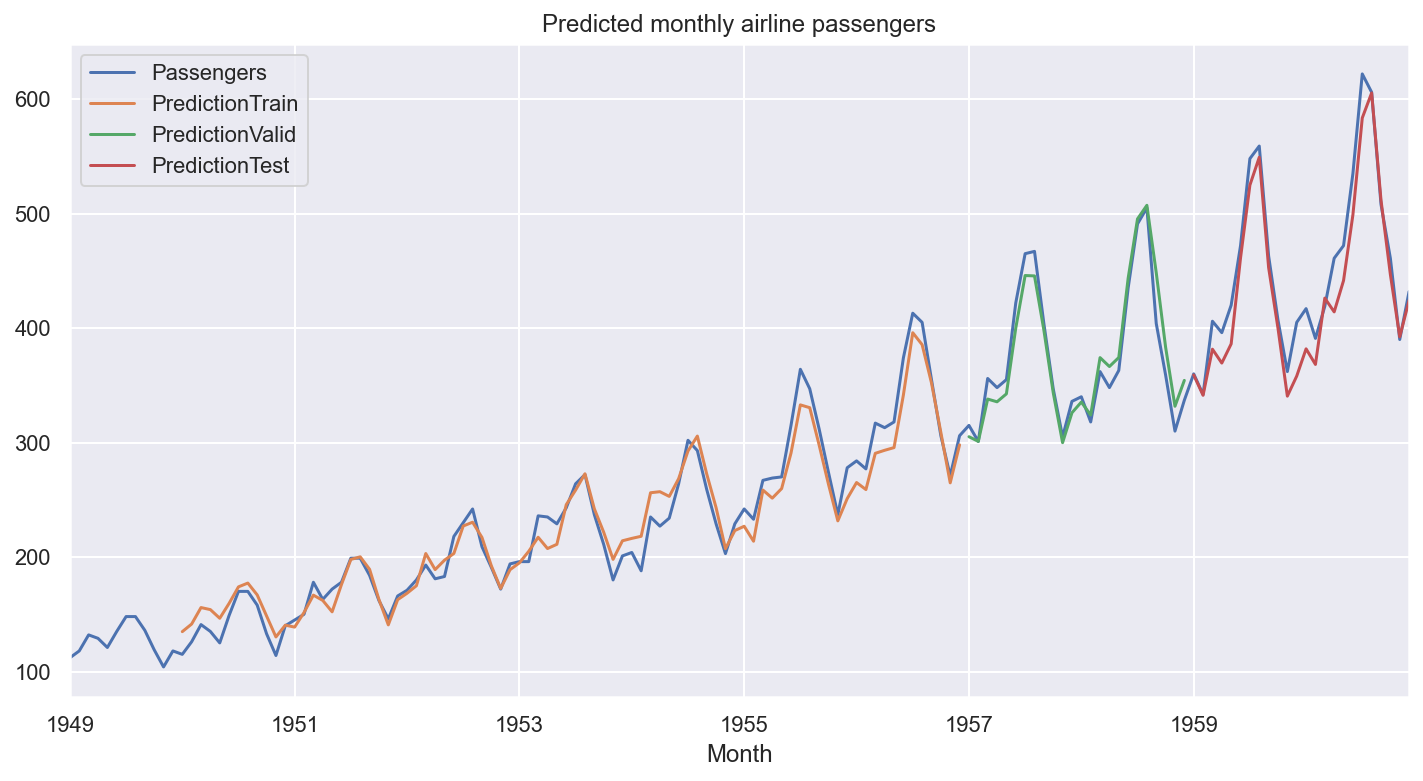

In [19]:
evaluate_model(data, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model)